In [ ]:
!pip install tensorflow opencv-python pillow tqdm kagglehub split-folders

In [2]:
import os
import shutil
from pathlib import Path
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



In [3]:
import kagglehub

print("Downloading dataset...")
path = kagglehub.dataset_download("gti-upm/leapgestrecog")
print("Dataset path:", path)


Using Colab cache for faster access to the 'leapgestrecog' dataset.
Dataset path: /kaggle/input/leapgestrecog


In [4]:
DATASET_ROOT = Path(path)

if (DATASET_ROOT / "leapGestRecog").exists():
    SRC_DIR = DATASET_ROOT / "leapGestRecog"
else:
    SRC_DIR = DATASET_ROOT

print("Using dataset from:", SRC_DIR)
print("Classes:", os.listdir(SRC_DIR))


Using dataset from: /kaggle/input/leapgestrecog/leapGestRecog
Classes: ['07', '05', '06', '02', '04', '00', '08', '09', '03', '01']


In [5]:
FLAT_DIR = Path("flat_data")
FLAT_DIR.mkdir(exist_ok=True)

print("Flattening dataset...")

for cls in os.listdir(SRC_DIR):
    cls_path = SRC_DIR / cls
    if not cls_path.is_dir():
        continue

    target_cls = FLAT_DIR / cls
    target_cls.mkdir(exist_ok=True)

    for sub in os.listdir(cls_path):
        sub_path = cls_path / sub
        if not sub_path.is_dir():
            continue

        for file in os.listdir(sub_path):
            src = sub_path / file
            if src.is_file():
                shutil.copy(src, target_cls / f"{sub}_{file}")

print("Flattening DONE ✅")


Flattening dataset...
Flattening DONE ✅


In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT
)



In [8]:
train_gen = train_datagen.flow_from_directory(
    FLAT_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    seed=42
)

val_gen = val_datagen.flow_from_directory(
    FLAT_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    seed=42
)


Found 16000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.


In [9]:
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)

for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [10]:
x = Flatten()(base_model.output)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.6)(x)
output = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(base_model.input, output)


In [11]:
model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)


In [13]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 272s 512ms/step - accuracy: 0.2229 - loss: 2.4417 - val_accuracy: 0.4317 - val_loss: 1.7632 - learning_rate: 1.0000e-04
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 250s 500ms/step - accuracy: 0.4638 - loss: 1.7263 - val_accuracy: 0.6683 - val_loss: 1.4670 - learning_rate: 1.0000e-04
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 251s 502ms/step - accuracy: 0.5678 - loss: 1.4449 - val_accuracy: 0.6948 - val_loss: 1.2771 - learning_rate: 1.0000e-04
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 253s 506ms/step - accuracy: 0.6189 - loss: 1.2857 - val_accuracy: 0.7303 - val_loss: 1.1788 - learning_rate: 1.0000e-04
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 248s 496ms/step - accuracy: 0.6602 - loss: 1.1560 - val_accuracy: 0.7172 - val_loss: 1.1360 - learning_rate: 1.0000e-04
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 265s 531ms/step - accuracy: 0.6911 - loss: 1.0722 - val_accuracy: 0.7450 - val_loss: 1.0129 - learning_rate: 1.0000e-04
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 

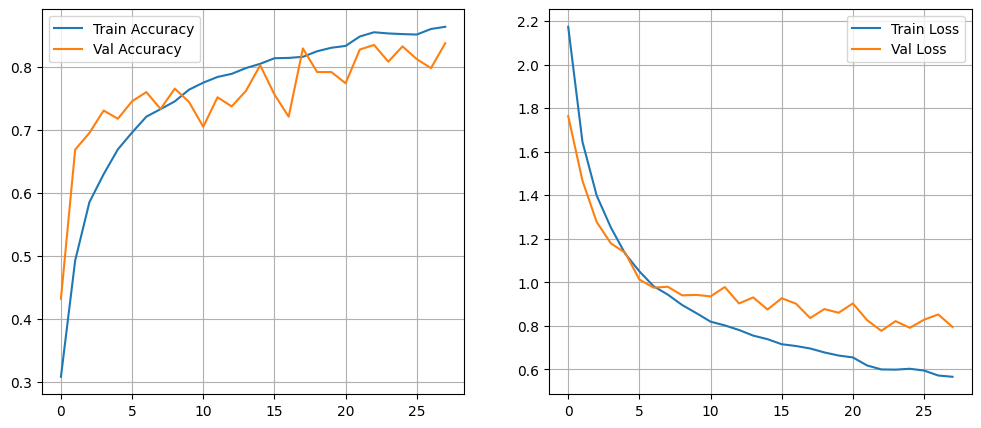

In [14]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.grid()

plt.show()


In [15]:
test_loss, test_acc = model.evaluate(val_gen)

print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.8451 - loss: 0.7509
Test Accuracy: 83.42%
Test Loss: 0.7772


In [16]:
train_acc = history.history['accuracy'][-1]

val_loss, val_acc = model.evaluate(val_gen, verbose=0)

test_acc = val_acc


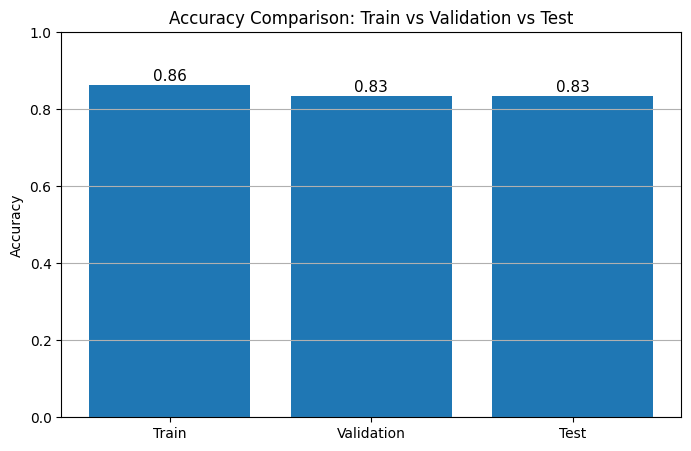

In [17]:
import matplotlib.pyplot as plt

labels = ['Train', 'Validation', 'Test']
accuracies = [train_acc, val_acc, test_acc]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, accuracies)

plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Train vs Validation vs Test")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}",
             ha='center', fontsize=11)

plt.grid(axis='y')
plt.show()
